# Bike Sharing with ML Pipelines

Spark ML offers a nice Pipeline API for building more complex transformation and machine learning pipelines. We will use these building blocks in this exercises

# Loading Data

First we need to load data from S3 or HDFS. We immediately read the data as CSV using Sparks builtin CSV parser.

In [3]:
from pyspark.sql.types import *

schema = StructType([
    StructField('row_id',IntegerType(),True),
    StructField('date',StringType(), True),
    StructField('season',IntegerType(), True),
    StructField('year',IntegerType(), True),
    StructField('month',IntegerType(), True),
    StructField('hour',IntegerType(), True),
    StructField('holiday',IntegerType(), True),
    StructField('weekday',IntegerType(), True),
    StructField('workingday',IntegerType(), True),
    StructField('weather',IntegerType(), True),
    StructField('temperature',DoubleType(), True),
    StructField('apparent_temperature',DoubleType(), True),
    StructField('humidity',DoubleType(), True),
    StructField('wind_speed',DoubleType(), True),
    StructField('casual',IntegerType(), True),
    StructField('registered',IntegerType(), True),
    StructField('counter',IntegerType(), True)
    ])

data = spark.read.schema(schema).csv('s3a://dimajix-training/data/bike-sharing/hour_nohead.csv')

## Inspect Data

Let us have a look at the first 10 entries again

In [4]:
data.limit(10).toPandas()

,row_id,date,season,year,month,hour,holiday,weekday,workingday,weather,temperature,apparent_temperature,humidity,wind_speed,casual,registered,counter
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


# Prepare for ML

Again we need to transform all numerical (and also categorical) entries to Doubles. This is required by most algorithms in ML.

In [5]:
from pyspark.sql.functions import *

ddata = data.select(
        data.date,
        unix_timestamp(data.date, "yyyy-MM-dd").alias('ts'),
        data.season.cast("double"),
        data.year.cast("double"),
        data.month.cast("double"),
        data.hour.cast("double"),
        data.holiday.cast("double"),
        data.weekday.cast("double"),
        data.workingday.cast("double"),
        data.weather.cast("double"),
        data.temperature,
        data.apparent_temperature,
        data.humidity,
        data.wind_speed,
        data.casual.cast("double"),
        data.registered.cast("double"),
        data.counter.cast("double")
    )

# Split Data

Before diving into the real world of Spark ML Pipelines, we split the data into a training set and a test set. Let us use 80% for training and 20% for validation.

In [6]:
train_data, test_data = ddata.randomSplit([0.8,0.2], seed=1)

print("train_data: %d" % train_data.count())
print("test_data: %d" % test_data.count())

train_data: 13785
test_data: 3594


# Create a ML Pipeline

Now we will create out first very simple pipeline using all numerical variables as features. This can be done very easily. We already know the two relevant classes performing the actual work

    VectorAssembler - extracts all features and stores them inside a Vector
    LinearRegression - performs the regression
    
We create a ML Pipeline with these two components. As features we'll again use the columns

    year, season, month, hour, holiday, weekday, workingday,
    weather, temperature, apparent_temperature, humidity, wind_speed
    
and of course we want to predict "counter". The prediction shall be stored in "prediction".   

In [7]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import *
from pyspark.ml.feature import *

pipeline = Pipeline(stages=[
    VectorAssembler(inputCols=['year','season','month','hour','holiday','weekday','workingday','weather','temperature','apparent_temperature','humidity','wind_speed'],outputCol='features'),
    LinearRegression(featuresCol='features', labelCol='counter', predictionCol='prediction')
])
model = pipeline.fit(train_data)

## Predict Data

Now that we have a model, we want to perform predictions for the test data. And let us also print a table with the first 10 entries of the predicted DataFrame

In [8]:
prediction = model.transform(test_data)

prediction.limit(10).toPandas()

,date,ts,season,year,month,hour,holiday,weekday,workingday,weather,temperature,apparent_temperature,humidity,wind_speed,casual,registered,counter,features,prediction
0,2011-01-01,1293840000,1.0,0.0,1.0,4.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0000,0.0,1.0,1.0,"[0.0, 1.0, 1.0, 4.0, 0.0, 6.0, 0.0, 1.0, 0.24,...",-29.356366
1,2011-01-01,1293840000,1.0,0.0,1.0,10.0,0.0,6.0,0.0,1.0,0.38,0.3939,0.76,0.2537,12.0,24.0,36.0,"[0.0, 1.0, 1.0, 10.0, 0.0, 6.0, 0.0, 1.0, 0.38...",61.901441
2,2011-01-01,1293840000,1.0,0.0,1.0,18.0,0.0,6.0,0.0,3.0,0.42,0.4242,0.88,0.2537,9.0,26.0,35.0,"[0.0, 1.0, 1.0, 18.0, 0.0, 6.0, 0.0, 3.0, 0.42...",102.653787
3,2011-01-01,1293840000,1.0,0.0,1.0,20.0,0.0,6.0,0.0,2.0,0.40,0.4091,0.87,0.2537,11.0,25.0,36.0,"[0.0, 1.0, 1.0, 20.0, 0.0, 6.0, 0.0, 2.0, 0.4,...",118.786209
4,2011-01-02,1293926400,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.46,0.4545,0.88,0.2985,4.0,13.0,17.0,"[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.46,...",-30.989705
5,2011-01-02,1293926400,1.0,0.0,1.0,9.0,0.0,0.0,0.0,2.0,0.38,0.3939,0.76,0.2239,1.0,19.0,20.0,"[0.0, 1.0, 1.0, 9.0, 0.0, 0.0, 0.0, 2.0, 0.38,...",37.676705
6,2011-01-02,1293926400,1.0,0.0,1.0,13.0,0.0,0.0,0.0,2.0,0.36,0.3485,0.66,0.1343,11.0,64.0,75.0,"[0.0, 1.0, 1.0, 13.0, 0.0, 0.0, 0.0, 2.0, 0.36...",71.796562
7,2011-01-02,1293926400,1.0,0.0,1.0,15.0,0.0,0.0,0.0,3.0,0.34,0.3333,0.81,0.1642,19.0,55.0,74.0,"[0.0, 1.0, 1.0, 15.0, 0.0, 0.0, 0.0, 3.0, 0.34...",50.562962
8,2011-01-02,1293926400,1.0,0.0,1.0,17.0,0.0,0.0,0.0,1.0,0.34,0.3333,0.57,0.1940,7.0,58.0,65.0,"[0.0, 1.0, 1.0, 17.0, 0.0, 0.0, 0.0, 1.0, 0.34...",121.416134
9,2011-01-02,1293926400,1.0,0.0,1.0,20.0,0.0,0.0,0.0,1.0,0.30,0.2727,0.39,0.3582,5.0,17.0,22.0,"[0.0, 1.0, 1.0, 20.0, 0.0, 0.0, 0.0, 1.0, 0.3,...",169.590468


# Make some Pictures again

Again we need to import matplotlib.pyplot and add some magic to display the plots inside the notebook

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

/opt/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Let us plot the total number of rents per day again, and let's compare that visually against the predictions.

(1293840000, 1356912000)

/opt/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


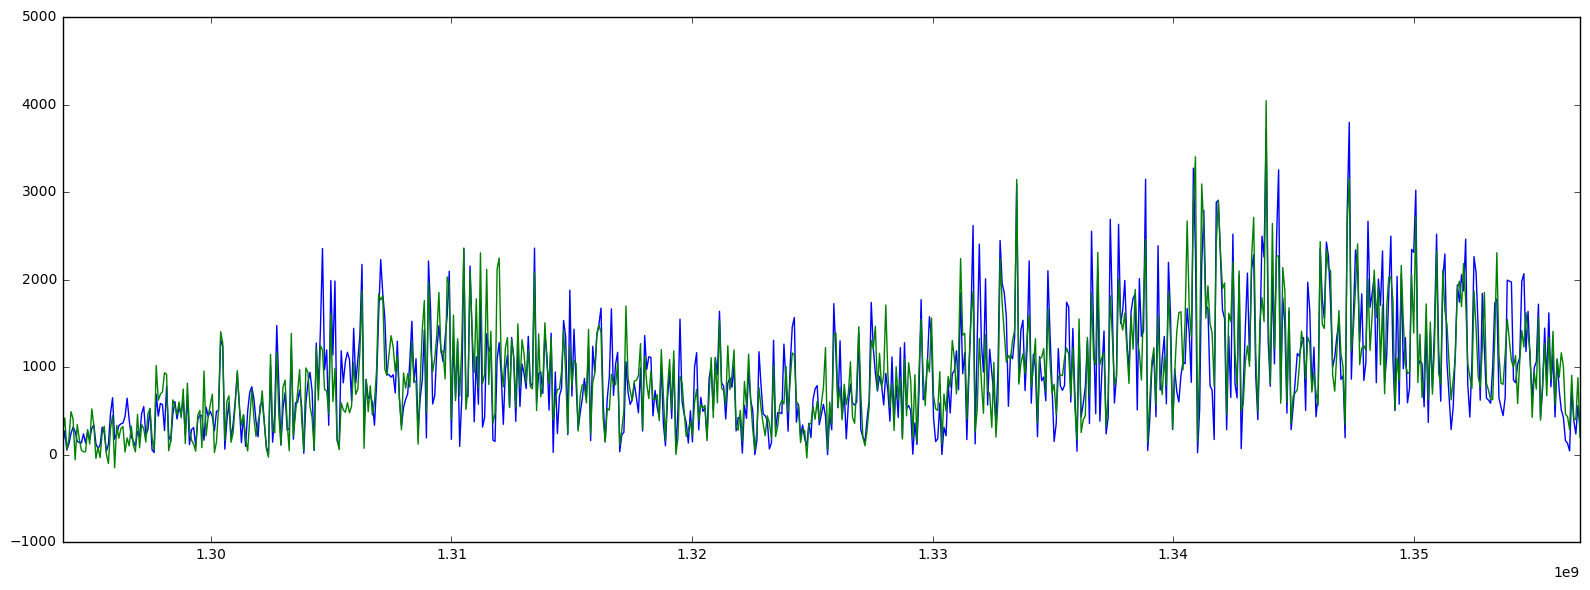

In [10]:
daily = prediction \
    .groupBy('ts').agg({'counter':'sum', 'prediction':'sum'}) \
    .orderBy('ts')
    
pdf = daily.toPandas()

min_ts,max_ts = prediction.agg(min('ts'), max('ts')).collect()[0]

plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k', tight_layout=True)
plt.plot(pdf['ts'],pdf['sum(counter)'])
plt.plot(pdf['ts'],pdf['sum(prediction)'])    
axes = plt.gca()
axes.set_xlim([min_ts,max_ts])

# Evaluate Model

Again we want to evaluate the resulting model using RegressionEvaluator from package pyspark.ml.evaluation.

In [11]:
from pyspark.ml.evaluation import *

evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='counter', metricName='rmse')

rmse = evaluator.evaluate(prediction)

print("RMSE of Simple Model = %f" % rmse)

RMSE of Simple Model = 141.359992


# Logarithmic Metric

In this example, we might not be so much interested about the absolute prediction error, but more about a relative prediction error. This can be expressed very well on a logarithmic scale. But we cannot use builtin evaluators for that, we need to create one on our own.

But first let us try to calculate the RMSE metric manually. RMSE is defined as

    sqrt(avg((predicted_value - true_value)**2)
    
And the the Root Mean Squared Logarithmic Error is defined as

    sqrt(avg((log(predicted_value) - log(true_value))**2)
    
Both metrics can be easily implemented using standard functionality of Spark DataFrames.

In [12]:
rmse = prediction.select(sqrt(avg((col('prediction') - col('counter'))**2)).alias('rmse')).collect()[0]
rmsle = prediction.select(sqrt(avg((log('prediction') - log('counter'))**2)).alias('rmsle')).collect()[0]

print("RMSE = %f" % rmse)
print("RMSLE = %f" % rmsle)

RMSE = 141.359992
RMSLE = 1.209344


## Logarthmic Model

Since our error metric is now in logarithmic space, it makes sense to optimize in that space, too. Therefore we switch to a logarithmic model.

We implement the logarithmic model by applying the following transformation to the "counter" column before fitting the linear model:

    lcounter = log(counter + 1)
    
Then we fit a linear regression model to the target variable lcounter (instead of counter). The predicted value should be stored in a column 'lprediction'.

But since eventually we are interested in the linear value (and not in the logarithmic value), we backtransform the predicted value from the logarithmic scale into the linear scale by

    prediction = exp(lprediction) - 1
    
In order to perform the Transformation, we can add multiple SQLTransformer at appropriate locations to the Pipeline. An SQLTransformer has one keyword argument

    SQLTransformer(statement="SELECT x+y AS z,* FROM __THIS__")
    
which will create DataFrames with a new column 'z' which is the sum of both columns 'x' and 'y'. Different SQLTransformers can be used for the transformation of the counter and lprediction variable.

In [13]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import *
from pyspark.ml.feature import *

pipeline = Pipeline(stages= [
    VectorAssembler(inputCols=['year','season','month','hour','holiday','weekday','workingday','weather','temperature','apparent_temperature','humidity','wind_speed'],outputCol='features'),
    SQLTransformer(statement="SELECT *,log(counter + 1) as lcounter FROM __THIS__"),
    LinearRegression(featuresCol='features', labelCol='lcounter', predictionCol='lprediction'),
    SQLTransformer(statement="SELECT *,exp(lprediction) - 1 as prediction FROM __THIS__")
])

logmodel = pipeline.fit(train_data)

## Evaluate Model

Again we want to calculate the RMSE and RMSLE for the test data using the new logarithmic model.

In [14]:
logprediction = logmodel.transform(test_data)

rmse = logprediction.select(sqrt(avg((col('prediction') - col('counter'))**2)).alias('rmse')).collect()[0]
rmsle = logprediction.select(sqrt(avg((log('prediction') - log('counter'))**2)).alias('rmsle')).collect()[0]

print("RMSE = %f" % rmse)
print("RMSLE = %f" % rmsle)

RMSE = 159.986995
RMSLE = 1.050999


# Make some Pictures again

(1293840000, 1356912000)

/opt/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


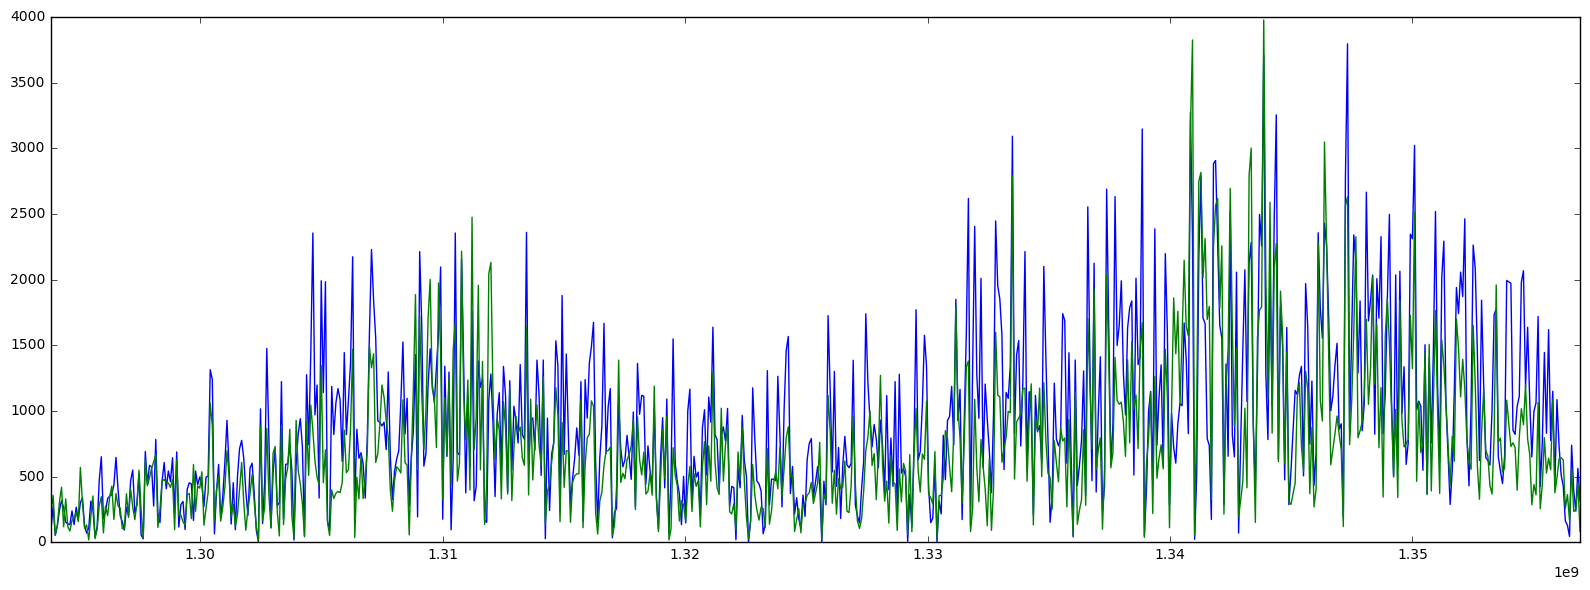

In [15]:
daily = logprediction \
    .groupBy('ts').agg({'counter':'sum', 'prediction':'sum'}) \
    .orderBy('ts')
    
pdf = daily.toPandas()

min_ts,max_ts = logprediction.agg(min('ts'), max('ts')).collect()[0]

plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k', tight_layout=True)
plt.plot(pdf['ts'],pdf['sum(counter)'])
plt.plot(pdf['ts'],pdf['sum(prediction)'])    
axes = plt.gca()
axes.set_xlim([min_ts,max_ts])

# Adding More Features

We might want to add more features in order to improve prediction quality. We propose the following additional features:

1. Features for modelling period effects of a year. This can be done by adding the two features:
        sin(ts / 31536000 * 6.28318531) 
        cos(ts / 31536000 * 6.28318531)
2. Similarily for modelling periodic effects within a week, the following features can be used:
        sin(weekday / 7 * 6.28318531)
        cos(weekday / 7 * 6.28318531)
3. And for modelling periodic effects within a single day the following features can be used:
        sin(hour / 24 * 6.28318531)
        cos(hour / 24 * 6.28318531)
4. season, one-hot encoded
5. weather, one-hot encoded

You can use SQLTransformer for arithmetic transformations and a combination of

    StringIndexer(inputCol='categoricalFeature', outputCol='categoricalIndex')
    OneHotEncoder(inputCol='categoricalIndex', outputCol='categoricalOneHot')
    
for creating one hot encoded categorical features.

In [16]:
pipeline2 = Pipeline(stages= [
    SQLTransformer(statement="""
        SELECT 
            *,
            sin(ts / 31536000 * 6.28318531) as ts_sin,
            cos(ts / 31536000 * 6.28318531) ts_cos, 
            sin(weekday / 7 * 6.28318531) as wd_sin, 
            cos(weekday / 7 * 6.28318531) as wd_cos,
            sin(hour / 24 * 6.28318531) as hour_sin, 
            cos(hour / 24 * 6.28318531) as hour_cos 
        FROM __THIS__
    """),
    StringIndexer(inputCol='season',outputCol='iseason'),
    OneHotEncoder(inputCol='iseason',outputCol='vseason'),
    StringIndexer(inputCol='weather',outputCol='iweather'),
    OneHotEncoder(inputCol='iweather',outputCol='vweather'),
    VectorAssembler(inputCols=['ts_sin','ts_cos','wd_sin','wd_cos','hour_sin','hour_cos','year','month','hour','holiday','weekday','workingday','temperature','apparent_temperature','humidity','wind_speed','vseason'],outputCol='features'),
    SQLTransformer(statement="SELECT *,log(counter + 1) as lcounter FROM __THIS__"),
    LinearRegression(featuresCol='features', labelCol='lcounter', predictionCol='lprediction'),
    SQLTransformer(statement="SELECT *,exp(lprediction) - 1 as prediction FROM __THIS__")
])
logmodel2 = pipeline2.fit(train_data)

## Evaluate new Model

Again we want to evaluate our new model using RMSE and RMSLE metrics.

In [17]:
logprediction2 = logmodel2.transform(test_data)
rmse = logprediction2.select(sqrt(avg((col('prediction') - col('counter'))**2)).alias('rmse')).collect()[0]
rmsle = logprediction2.select(sqrt(avg((log('prediction') - log('counter'))**2)).alias('rmsle')).collect()[0]

print("RMSE = %f" % rmse)
print("RMSLE = %f" % rmsle)

RMSE = 140.782137
RMSLE = 0.868254
